In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*Now that we have the fundamental performance equations for different regimes of flight, what remains is the need to find appropriate values to substitute into each expression. Notably, most equations depend on a means of estimating drag, which we assumed would be possible using a function of the form $C_D = f(C_L)$. In this notebook, we explore such functions, which are generally expressed graphically in **drag polar** diagrams.*

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from ADRpy.mtools4acdc import recastasnpfloatarray

# Aircraft Performance L2 - Modelling the Drag Polar

## The simple, quadratic drag model

The drag force an aircraft experiences during flight can be considered the sum of drag forces, distinguished by their source

$$
D = D_0 + D_f + D_i + D_w + D_{\text{misc}}
$$

where the total drag $D$ is the sum of
- $D_0$, basic drag (pressure drag due to pressure distribution and shape)
- $D_f$, skin friction drag (due to viscous effects and surface roughness)
- $D_i$, induced drag (pressure drag due to lift, vortex drag)
- $D_w$, wave drag (from compressibility effects, drag due to volume)
- $D_{\text{misc}}$ miscellaneous additive drag (from interference between components, antenna bumps, etc.)

To compare aircraft of different types, its helpful to non-dimensionalise drag forces into *drag coefficients*.
Furthermore, we'll just consider the forces on subsonic aircraft and neglect wave drag

$$D = \tfrac{1}{2} \rho V^2 S C_D$$
<!-- Package required for cancellation symbol -->
$$\require{cancel}\implies C_D = C_{D_0} +C_{D_f} + C_{D_i} + \cancel{C_{D_w}} + C_{D_\text{misc}}$$

where the drag force has been normalised by the ambient air density $\rho$, the freestream velocity $V$, and reference wing area $S$.

Prandtl's lifting line theory tells us that $C_{D_i} \propto {C_L}^2$

$$
C_D = C_{D_0} + C_{D_f} + \frac{{C_L}^2}{\pi e \text{AR}} + C_{D_{\text{misc}}}
$$

where we have introduced the planform *span efficiency factor* $e$ and the wing's effective aspect ratio $AR$.

It is important to understand at this point that $C_{D_0}$ is not a constant.
This is because the separation of flow from a wing due to high angle of attack is a product of the shape of the aerodynamic body.
> 💡 It might help to envision think about how a flat plate wing's drag would increase as high $\alpha$ causes it to stall, but a golf ball will have the same separation drag no matter what "angle of attack" you subject it to!

Despite us having a *lift-induced* drag coefficient $C_{D_i}$, there are actually lift-induced components of profile drag too.
To make modelling easier, we will consider a breakdown of $C_{D_0}$ into constant and lift-dependent components.
For reasons that will become evident momentarily, we assume that $C_{D_0}$ has a quadratic dependence on lift

$$
C_{D_0}
\ \doteq \ \langle {C_{D_0}} \rangle + m \cdot {C_L}^2
$$

where $\langle{C_{D_0}}\rangle$ is a constant term representing the zero-lift component of profile drag, and $m$ has been introduced as some constant of proportionality.
Our expression of drag now reads

$$
C_D = \langle C_{D_0} \rangle + C_{D_f} + \left(m + \frac{1}{\pi e \text{AR}}\right) \cdot {C_L}^2 + C_{D_{\text{misc}}}
$$

We'll introduce the *induced drag factor* $k$ to represent $C_D$'s proportionality to ${C_L}^2$

$$
\longrightarrow \quad
C_D = \langle C_{D_0} \rangle + C_{D_f} + k \cdot {C_L}^2 + C_{D_{\text{misc}}}
$$

where $k$ can be estimated from the aircraft's *Oswald efficiency factor* $e$

$$
k
= \ m + \frac{1}{\pi e \text{AR}}
= \frac{1}{\pi e_0 \text{AR}}
\quad \text{where} \quad
e_0 \doteq \frac{e}{1 + m \cdot \pi e \text{AR}}
$$

$$
C_{D_i} = k \cdot {C_L}^2
\quad \longleftrightarrow \quad
C_{D_i} = \frac{{C_L}^2}{\pi e_0 \text{AR}}
$$

Since $m \geq 0$, necessarily $e_0 \leq e$.

Furthermore, we can collect the terms $\langle C_{D_0} \rangle$, $C_{D_f}$, and $C_{D_{\text{misc}}}$ (by treating them effectively as constant) into minimum drag, $C_{D_{\text{min}}}$ (also known as profile drag or zero-lift drag).
This leaves us with

$$C_D = C_{D_\text{min}} + k \cdot {C_L}^2$$

Under the hood you now know $k$ has been defined to depend on $e_0$ (not $e$ !), and therefore it accounts for many types of drag due to lift.
This is important because in the world of empirical approaches to estimating induced drag, many methods produce estimates for the Oswald span efficiency factor $e_0$.

## The drag polar

A *drag polar* is one of several so-called aircraft *polar diagrams* - presumably because they are traditionally a function of the aircraft's (or any aerodynamic body's) angle of attack $\alpha$.
Since both lift and drag forces are functions of $\alpha$, it is common to see $C_L$ plotted against $C_D$ (implicitly polar).

In [3]:
def drag_simple(CDmin, k, CL):
    CD = CDmin + k * CL ** 2
    return CD

We'll showcase this model with an example

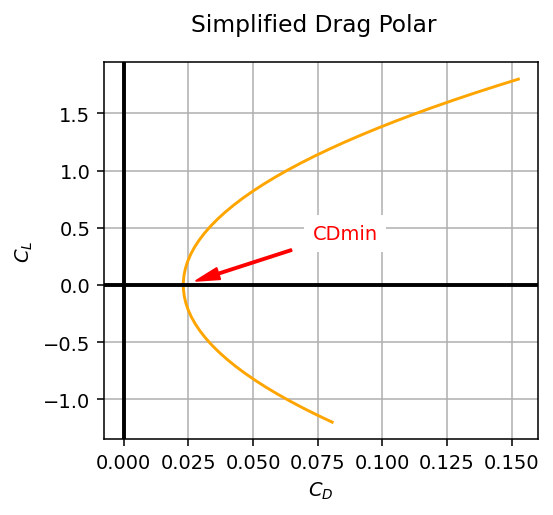

In [4]:
# Drag model parameters
CDmin = 0.023
k = 0.04

# Get data
ys_simple = np.linspace(-1.2, 1.8)
xs_simple = drag_simple(CDmin=CDmin, k=k, CL=ys_simple)

# Make a plot
fig, ax = plt.subplots(dpi=140, figsize=(4, 3.5))
fig.suptitle("Simplified Drag Polar")
ax.plot(xs_simple, ys_simple, c="orange")
ax.annotate("CDmin", (CDmin, 0), (CDmin+.05, 0.4), c="r", backgroundcolor="w",
            arrowprops={"color": "r", "shrink":0.1, "headwidth": 6, "width": 1})

def prettyplot(axes_obj):
    axes_obj.set_xlabel("$C_D$")
    axes_obj.set_ylabel("$C_L$")
    axes_obj.axvline(0, c="k", lw=2)
    axes_obj.axhline(0, c="k", lw=2)
    axes_obj.grid();

prettyplot(ax)

## The Adjusted drag model

A comparison of the simplified drag model with given polars of modern aircraft will reveal three problems:
1. Aircraft often have drag polars that are not symmetrical about the x-axis ($C_L=0$), but instead around the coefficient of lift for minimum drag $C_{L,\text{minD}}$.
2. Near the stalling angle of attacks (for $\pm \text{ve}$ stalls), the polar is *not* quadratic.
3. Some aircraft use aerofoils for which their polars include *drag buckets*, a small region around $C_{L,\text{minD}}$ in which the drag coefficient is smaller than the simple quadratic model would predict.

The first problem is pretty trivial - we can transform the polar so that the axis of symmetry lies at $C_{L,\text{minD}}$

In [5]:
def drag_adjust(CDmin, k, CL, CLminD=0):
    CLeffective = CL - CLminD
    CD = drag_simple(CDmin=CDmin, k=k, CL=CLeffective)
    return CD

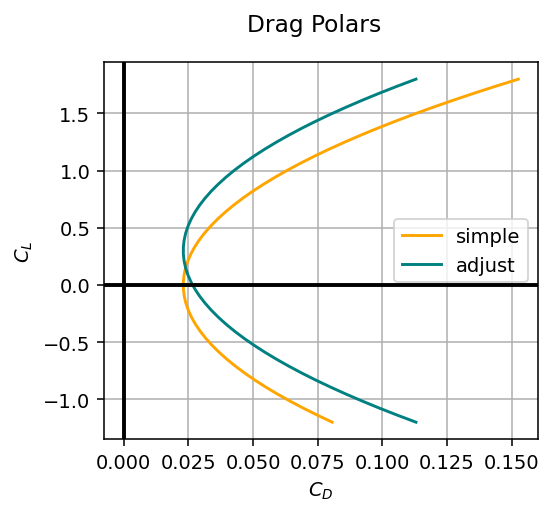

In [6]:
# New drag model parameter
CLminD = 0.30

# Get data
xs_adjust = drag_adjust(
    CDmin=CDmin, k=k, CL=ys_simple, CLminD=CLminD)

# Make a plot
fig, ax = plt.subplots(dpi=140, figsize=(4, 3.5))
fig.suptitle("Drag Polars")
ax.plot(xs_simple, ys_simple, c="orange", label="simple")
ax.plot(xs_adjust, ys_simple, c="teal", label="adjust")
ax.legend()
prettyplot(ax)

To account for the non-quadratic behaviour of the drag polar at $C_L$ approaching stall, we consider a quadratic spline fitting method outlined in [[1]](#References).

In [7]:
def drag_modify(CDmin, k, CL, CLmax, CLminD=0):
    # Recast as necessary
    CL = recastasnpfloatarray(CL)
    
    # Estimate point of switching to quadratic spline
    CLm = 0.5 * (CLminD + CLmax)
    
    # Estimate the CDstall about 180% of the quadratic model
    CDstall = 1.8 * drag_adjust(
        CDmin=CDmin, k=k, CL=CLmax, CLminD=CLminD)
    
    # As per [1], fit a spline to produce a modified drag model
    matA = np.array([
        [  CLm ** 2,   CLm, 1],
        [   2 * CLm,     1, 0],
        [CLmax ** 2, CLmax, 1]
    ])
    matB = np.array([
        drag_adjust(CDmin=CDmin, k=k, CL=CLm, CLminD=CLminD),
        2 * k * (CLm - CLminD),
        CDstall
    ])
    A, B, C = np.linalg.solve(matA, matB)
    CDmod = A * CL ** 2 + B * CL + C
    
    # Switch between models as we need to
    CDquad = drag_adjust(CDmin=CDmin, k=k, CL=CL, CLminD=CLminD)
    CD = np.where(CL <= CLm, CDquad, CDmod)
    
    return CD

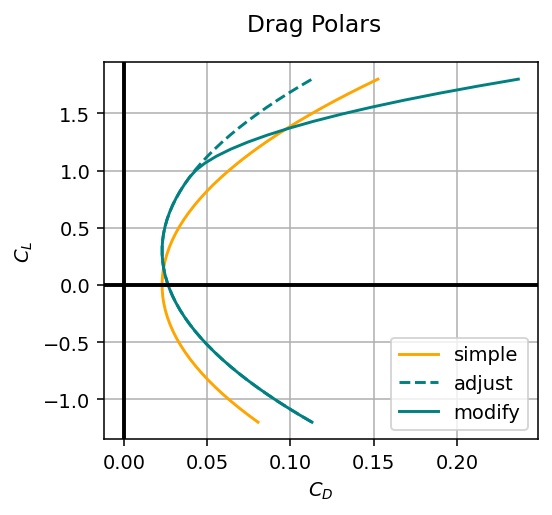

In [8]:
# New drag model parameter
CLmax = 1.6

# Get data
xs_modify = drag_modify(
    CDmin=CDmin, k=k, CL=ys_simple, CLmax=CLmax, CLminD=CLminD)

# Make a plot
fig, ax = plt.subplots(dpi=140, figsize=(4, 3.5))
fig.suptitle("Drag Polars")
ax.plot(xs_simple, ys_simple, c="orange", label="simple")
ax.plot(xs_adjust, ys_simple, c="teal", label="adjust", ls="--")
ax.plot(xs_modify, ys_simple, c="teal", label="modify")
ax.legend()
prettyplot(ax)

For now, we ignore the third issue and acknowledge this as a caveat of our modelling assumptions at the concept stage.

What we're left with is a drag model as a function of some fairly easy to estimate parameters:
- The minimum drag coefficient, $C_{D,\text{min}}$
- The coefficient of lift at which drag should be evaluated, $C_L$
- The maximum attainable coefficient of lift before stall, $C_{L\text{max}}$
- The coefficient of lift at which the minimum drag condition is achieved, $C_{L,\text{minD}}$

and one, slightly more difficult to estimate parameter, the *induced drag factor* $k$.
We'll take a look at this in the next notebook.

# References

[1]  Gudmundsson, S., "General Aviation Aircraft Design: Applied Methods and Procedures", Butterworth-Heinemann, 2013. 